In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import glob
from scipy.ndimage import uniform_filter
from scipy.linalg import lstsq
import batman
from chromatic import Rainbow
import astropy.units as u

In [2]:
P = 0.7668944
T0 = 57518.34377
DAY_TO_SEC = 86400

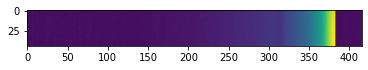

In [3]:
hdul = fits.open("x1d_bkdsub_rateints_ERS_NGTS10_2022_seg_000.fits")
plt.imshow(hdul[1].data)

In [4]:
filenames = glob.glob("x1d_bkdsub_rateints_ERS_NGTS10_2022_seg_???.fits")
phases = []
mjds = []
data = []

for filename in filenames:
    with fits.open(filename) as hdul:        
        header = hdul[0].header
        #print(hdul[4].data)
        wavelengths = hdul[4].data["WAVELENGTH"]
        #print(wavelengths)
        times = header["EXSEGNUM"] * header["EFFINTTM"] * header["NINTS"] + np.linspace(0, header["EFFINTTM"] * header["NINTS"], header["NINTS"])
        #wavelengths = hdul["WAVELENGTH"].data
        mjds += list(times / DAY_TO_SEC)
        phases += list(times / DAY_TO_SEC / P)
        data += list(hdul["SPECTRA"].data)
        #print(len(phases), len(data))
        #print(np.linspace(0, header["EXSEGNUM"] * header["EFFINTTM"] * header["NINTS"] / DAY_TO_SEC / P, header["NINTS"]))
        #print(phases[-1])
        #print(len(phases[-1]))#, len(data[-1]))
        
argsort = np.argsort(phases)
mjds = np.array(mjds)[argsort]
phases = np.array(phases)[argsort] - 0.71
data = np.array(data)[argsort]

cond = np.logical_and(wavelengths > 5, wavelengths < 12)
wavelengths = wavelengths[cond]
data = data[:,cond]

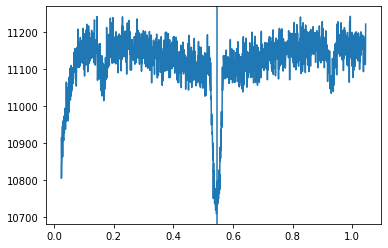

In [5]:
plt.plot(mjds, np.sum(data, axis=1))
plt.axvline(0.545)

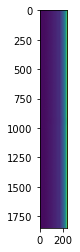

In [6]:
plt.imshow(data)

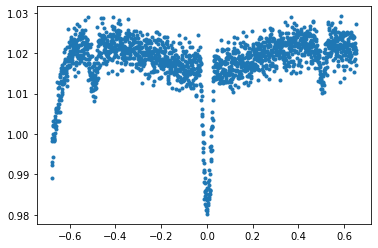

In [7]:
%matplotlib inline
plt.plot(phases, np.sum(data, axis=1) / 10925, '.')
plt.show()

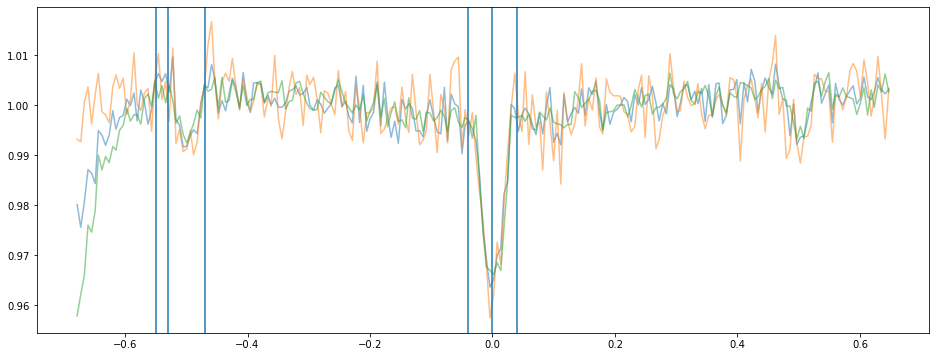

In [11]:
def plot(phases, data, lower, upper, binsize):
    fluxes = np.sum(data[:, lower:upper], axis=1)
    fluxes /= np.median(fluxes)
    plt.plot(phases[::binsize], fluxes[::binsize], alpha=0.5)


fluxes = np.sum(data, axis=1)
fluxes /= np.median(fluxes)
binsize = 8
flattened_fluxes = uniform_filter(fluxes, binsize)
plt.figure(figsize=(16,6))
#plt.plot(phases[::binsize], flattened_fluxes[::binsize])
#plt.plot(phases[::binsize], np.sum(data[:,200:234], axis=1)[::binsize])
plot(phases, data, 0, 234, binsize)
#plot(phases, data, 100, 150, binsize)
plot(phases, data, 150, 200, binsize)
plot(phases, data, 200, 234, binsize)
#plt.xlim(0, )
plt.axvline(0.0)
plt.axvline(-0.04)
plt.axvline(0.04)
plt.axvline(-0.55)

plt.axvline(-0.53)
plt.axvline(-0.47)

exclude = np.any([phases < -0.55, np.abs(phases) < 0.04, np.abs(phases - 0.5) < 0.03, np.abs(phases + 0.5) < 0.03], axis=0)
#print(exclude)
#plt.figure()
#flattened_fluxes[exclude] = np.nan
#plt.plot(phases[::binsize], flattened_fluxes[::binsize], '.')


(-0.005, 0.005)

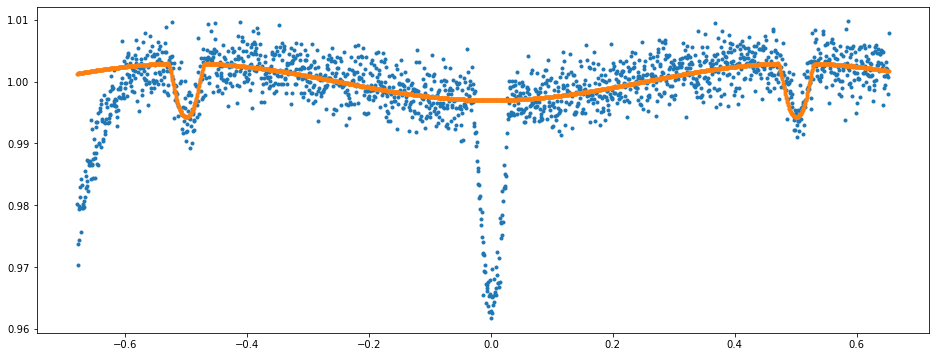

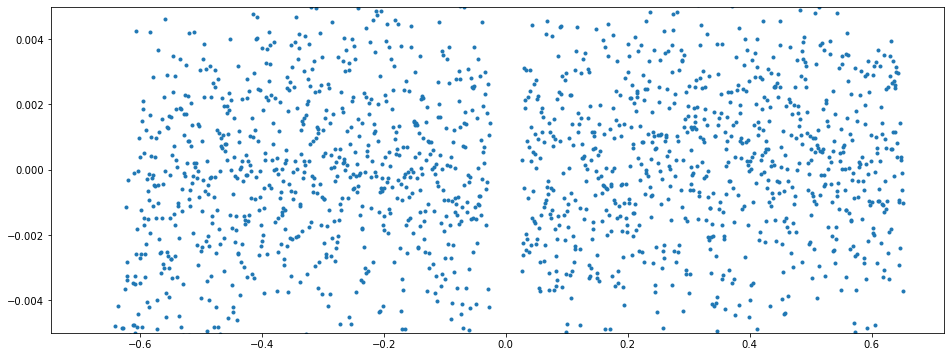

In [49]:
def get_batman_params(t0, per, rp, a, inc, limb_dark_coeffs, \
                      t_secondary=None, w=0, ecc=0):
    params = batman.TransitParams()  # object to store transit parameters
    params.t0 = t0  # time of inferior conjunction
    params.per = per  # orbital period
    params.rp = rp  # planet radius (in units of stellar radii)
    params.a = a  # semi-major axis (in units of stellar radii)
    params.inc = inc  # orbital inclination (in degrees)
    params.ecc = ecc  # eccentricity
    params.w = w  # longitude of periastron (in degrees)
    params.limb_dark = "nonlinear"  # limb darkening model
    params.u = limb_dark_coeffs
    params.fp = 1 #we want eclipse to have no planet light

    if t_secondary is None:
        params.t_secondary = params.t0 + params.per / 2
    else:
        params.t_secondary = t_secondary

    return params

batman_params = get_batman_params(0.545, P, 0.1765, 4.447, 79,  [0.203, 0.1, -0.16, 0.071])
#transit_model = batman.TransitModel(initial_batman_params, bjds)
eclipse_model = batman.TransitModel(batman_params, mjds, transittype='secondary')


plt.figure(figsize=(16,6))
plt.plot(phases, fluxes, '.')
Fp = 6e-3
Lplanet = (Fp + 3e-3 * np.cos(2*np.pi*(phases - 0.5))) * (eclipse_model.light_curve(batman_params) - 1)
expected = 1 + Lplanet - Fp
plt.plot(phases, expected, '.')
#plt.ylim(0.99, 1.01)
plt.figure(figsize=(16,6))
plt.plot(phases, fluxes - expected, '.')
plt.ylim(-0.005, 0.005)

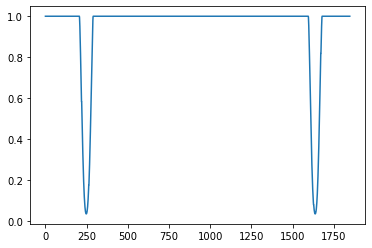

In [27]:
plt.plot(eclipse_model.light_curve(batman_params) - 1)

[ 1.00018185e+00  4.42604684e-05 -3.07944089e-03]
-0.5302154530351222
Ampltiude 0.0030797589446771106
Phase (deg) -0.8234492988998738


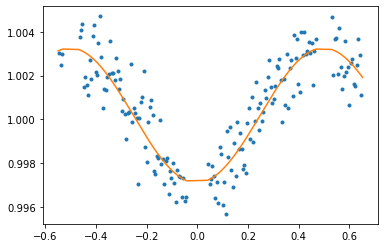

In [19]:
#Fit sine and cosine
included_phases = phases[~exclude]
included_fluxes = flattened_fluxes[~exclude]
A = np.array([np.ones(len(included_phases)), np.sin(2*np.pi*included_phases), np.cos(2*np.pi*included_phases)]).T
coeffs, _, _, _ = lstsq(A, included_fluxes)
print(coeffs)

predicted = A.dot(coeffs)
print(included_phases[np.argmax(predicted)])

print("Ampltiude", np.sqrt(coeffs[1]**2 + coeffs[2]**2))
print("Phase (deg)", 180/np.pi * np.arctan2(coeffs[1], coeffs[2]) - 180)


plt.plot(phases[::binsize], flattened_fluxes[::binsize], '.')
plt.plot(included_phases, predicted)

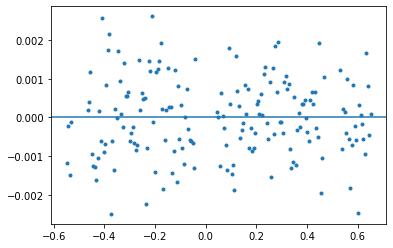

In [24]:
plt.plot(phases[~exclude][::binsize], (flattened_fluxes[~exclude] - predicted)[::binsize], '.')
plt.axhline(0)

In [227]:
included_phases = phases[~exclude]
amplitudes = []
phases = []
A = np.array([np.ones(len(included_phases)), np.sin(2*np.pi*included_phases), np.cos(2*np.pi*included_phases)]).T

for c in range(data.shape[1]):
    this_data = np.copy(data[:,c][~exclude])
    this_data /= np.median(this_data)
    coeffs, _, _, _ = lstsq(A, this_data)
    #print(c, coeffs)
    amplitudes.append(np.sqrt(coeffs[1]**2 + coeffs[2]**2))
    phases.append(180/np.pi * np.arctan2(coeffs[1], coeffs[2]) - 180)
    if phases[-1] < -180:
        phases[-1] += 360
    

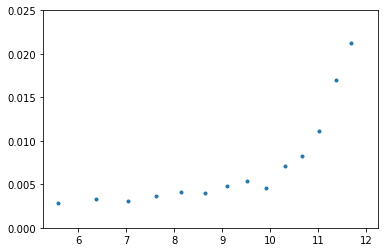

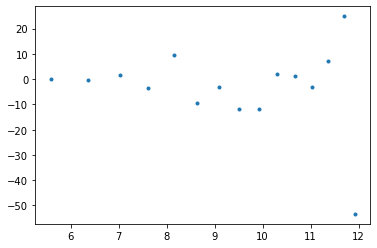

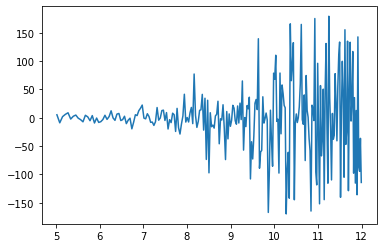

In [228]:
plt.plot(uniform_filter(wavelengths, 16)[::16], uniform_filter(amplitudes, 16)[::16], '.')
plt.ylim(0, 0.025)

plt.figure()
#plt.plot(uniform_filter(wavelengths, 16)[::16], uniform_filter(phases, 16)[::16], '.')
#plt.ylim(0, 0.025)
#phases[phases < 0]
#phases = np.array(phases)
plt.plot(uniform_filter(wavelengths, 16)[::16], uniform_filter(phases, 16)[::16], '.')

plt.figure()
plt.plot(wavelengths, phases)

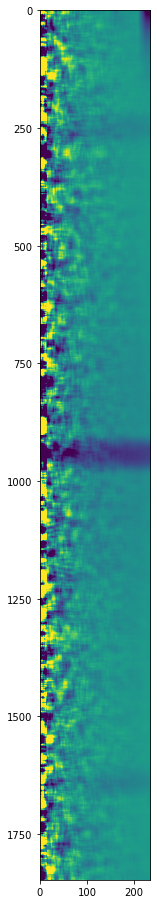

In [235]:
plt.figure(figsize=(16,16))
plt.imshow(uniform_filter(data / np.mean(data, axis=0), [16,16]), vmin=0.95, vmax=1.05)

(0.17, 0.2)

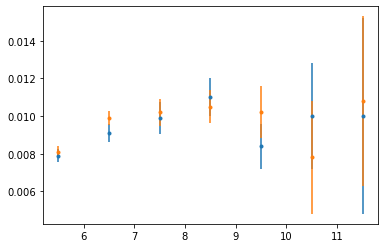

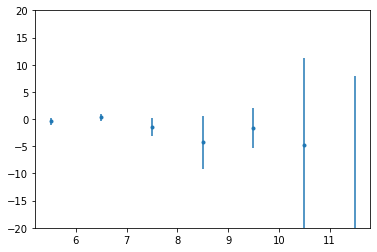

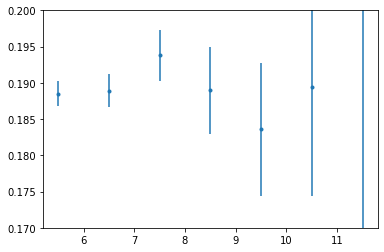

In [14]:
min_wavelengths, max_wavelengths, A, A_err, phi, phi_err, Fp, Fp_err, RpRs, RpRs_err = np.loadtxt("retrieved_spectrum", unpack=True)
wavelengths = (min_wavelength + max_wavelengths) / 2

plt.errorbar(wavelengths, Fp, yerr=Fp_err, fmt='.')
plt.errorbar(wavelengths, 3*A, yerr=3*A_err, fmt='.')
plt.figure()
plt.errorbar(wavelengths, phi, yerr=phi_err, fmt='.')
plt.ylim(-20, 20)
plt.figure()
plt.errorbar(wavelengths, RpRs, yerr=RpRs_err, fmt='.')
plt.ylim(0.17, 0.20)

In [2]:
min_wavelengths, max_wavelengths, A_med, A_lower_err, A_upper_err, phi_med, phi_lower_err, phi_upper_err, Fp_med, Fp_lower_err, Fp_upper_err, RpRs_med, RpRs_lower_err, RpRs_upper_err = np.loadtxt("result.txt", unpack=True)
wavelengths = (min_wavelengths + max_wavelengths) / 2

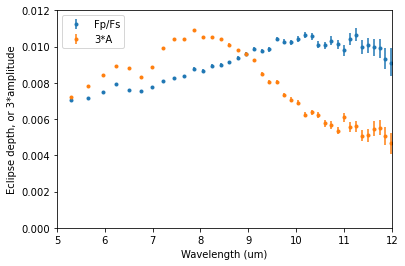

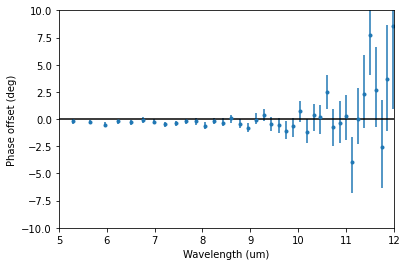

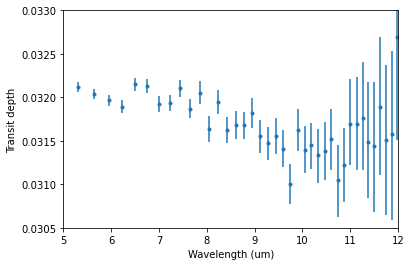

In [8]:
plt.errorbar(wavelengths, Fp_med, yerr=[Fp_lower_err, Fp_upper_err], fmt='.', label="Fp/Fs")
plt.errorbar(wavelengths, 3*A_med, yerr=[3*A_lower_err, 3*A_upper_err], fmt='.', label="3*A")
plt.xlim(5, 12)
plt.ylim(0, 0.012)
plt.legend()
plt.xlabel("Wavelength (um)")
plt.ylabel("Eclipse depth, or 3*amplitude")
plt.savefig("emission.png")
plt.figure()

plt.errorbar(wavelengths, phi_med, yerr=[phi_lower_err, phi_upper_err], fmt='.')
plt.xlim(5, 12)
plt.ylim(-10, 10)
plt.axhline(0, color='k')
plt.xlabel("Wavelength (um)")
plt.ylabel("Phase offset (deg)")
plt.savefig("phase_offset.png")
plt.figure()

plt.errorbar(wavelengths, RpRs_med**2, yerr=[2 * RpRs_med * RpRs_lower_err, 2 * RpRs_med * RpRs_upper_err], fmt='.')
plt.xlim(5, 12)
plt.ylim(0.0305, 0.033)
plt.xlabel("Wavelength (um)")
plt.ylabel("Transit depth")
plt.savefig("transit.png")

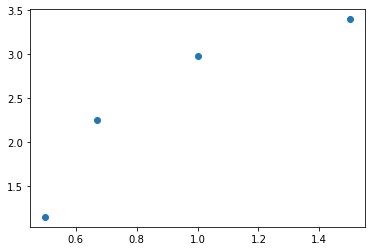

In [27]:
fluxes = np.array([0.5, 0.67, 1, 1.5])
depths = np.array([1.15, 2.25, 2.98, 3.4])
plt.scatter(fluxes, depths)
#plt.set_logscale()

In [2]:
r = Rainbow("lightcurves.txt")

100%|██████████| 118272/118272 [00:13<00:00, 8568.24it/s]


5.306041652817175 micron


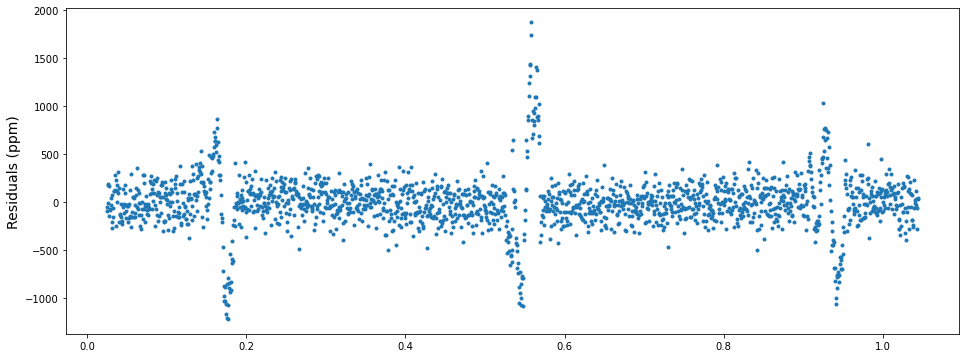

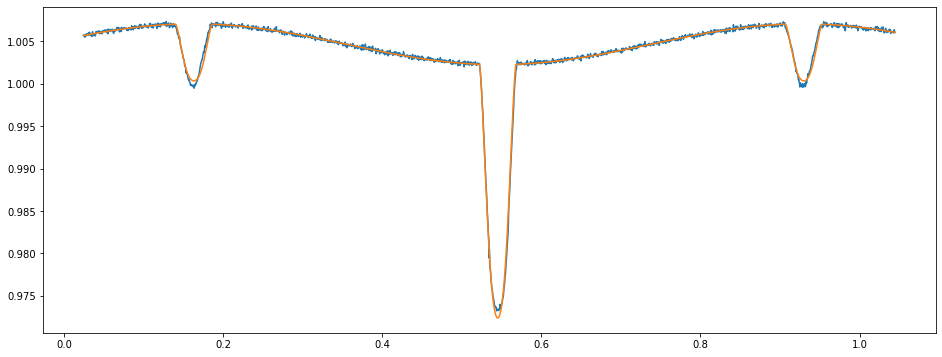

In [10]:
plt.figure(figsize=(16,6))
index = 2
print(r.wavelength[index])
plt.plot(r.time, 1e6 * r.fluxlike["residuals"][index], '.')
plt.ylabel("Residuals (ppm)", fontsize=14)
plt.savefig("residuals.png")
plt.figure(figsize=(16,6))
plt.plot(r.time, r.fluxlike["flux"][index])
plt.plot(r.time, r.fluxlike["model"][index])
plt.savefig("model_and_data.png")

159.54137234587137


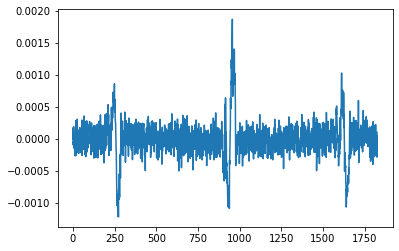

In [14]:
plt.plot(r.fluxlike["residuals"][index])
print(1e6*np.std(r.fluxlike["residuals"][2,500:750]))


🌈 Warning: 
Uncertainties and/or data quality flags might
not be handled absolutely perfectly yet...


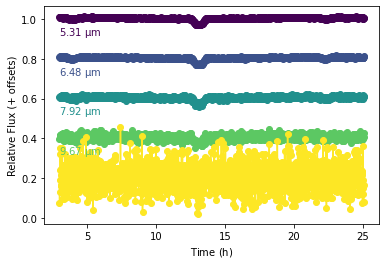

In [14]:
r.bin(R=5).plot(spacing=0.2)

In [58]:
binned = r.bin(R=10).bin(dt=10*u.minute)

<ErrorbarContainer object of 3 artists>

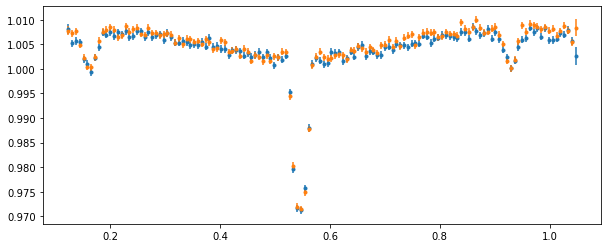

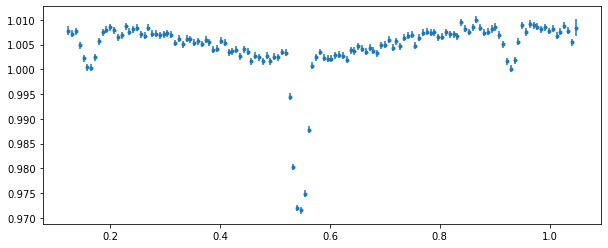

In [54]:
plt.figure(figsize=(10,4))
plt.errorbar(binned.time.value, binned.flux[0], yerr=binned.uncertainty[0], fmt='.')
plt.errorbar(binned.time.value, binned.flux[1], yerr=binned.uncertainty[1], fmt='.')
#binned.time.value
plt.figure(figsize=(10,4))
plt.errorbar(binned.time.value, binned.flux[1], yerr=binned.uncertainty[1], fmt='.')

In [55]:
binned.flux.shape

(9, 134)

In [57]:
r.wavelength

<Quantity [ 5.30604165,  5.64594154,  5.95442437,  6.23844548,  6.5053906 ,
            6.7571752 ,  6.99477585,  7.22349636,  7.4420675 ,  7.65363518,
            7.85636427,  8.05252118,  8.24186024,  8.4267665 ,  8.60662786,
            8.78145197,  8.95162239,  9.11786136,  9.28103451,  9.43929356,
            9.59484358,  9.74846802,  9.89775266, 10.04403853, 10.18825513,
           10.32926685, 10.46814306, 10.60453386, 10.73910938, 10.87154569] micron>


🌈 Warning: 
Uncertainties and/or data quality flags might
not be handled absolutely perfectly yet...


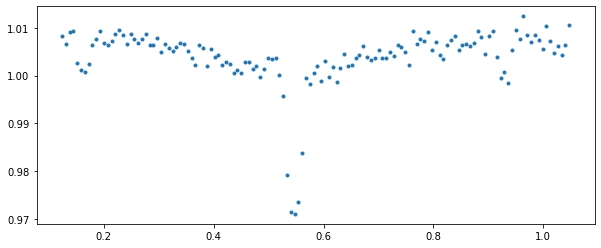

In [63]:
time_binned = r.bin(dt=10*u.minute)
plt.figure(figsize=(10,4))
plt.plot(time_binned.time, time_binned.flux[4], '.')
#r.time

In [54]:
min_wavelengths, max_wavelengths, A_med, A_lower_err, A_upper_err, phi_med, phi_lower_err, phi_upper_err, Fp_med, Fp_lower_err, Fp_upper_err, RpRs_med, RpRs_lower_err, RpRs_upper_err = np.loadtxt("result.txt", unpack=True)
#wavelengths = (min_wavelengths + max_wavelengths) / 2

#write eclipse depths
with open("eclipse_depths.txt", "w") as f:
    f.write("#wavelength_lower wavelength_upper depth uncertainty\n")
    for i in range(len(min_wavelengths)):
        f.write("{} {} {} {}\n".format(min_wavelengths[i], max_wavelengths[i], Fp_med[i], (Fp_lower_err[i] + Fp_upper_err[i])/2))

transit_depths = RpRs_med**2
RpRs_unc = (RpRs_lower_err + RpRs_upper_err) / 2
transit_err = 2 * RpRs_unc * RpRs_med

with open("transit_depths.txt", "w") as f:
    f.write("#wavelength_lower wavelength_upper depth uncertainty\n")
    for i in range(len(min_wavelengths)):
        f.write("{} {} {} {}\n".format(min_wavelengths[i], max_wavelengths[i], transit_depths[i], transit_err[i]))